In [1]:
import torch
import numpy as np
from PIL import Image

from transformers import DPTFeatureExtractor, DPTForDepthEstimation
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL
from diffusers.utils import load_image

/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to("cuda")
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0",
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
).to("cuda")
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to("cuda")
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
).to("cuda")
pipe.enable_model_cpu_offload()


config.json: 100%|██████████| 9.88k/9.88k [00:00<00:00, 13.7MB/s]
pytorch_model.bin: 100%|██████████| 490M/490M [00:04<00:00, 115MB/s]  
/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
preprocessor_config.json: 100%|██████████| 382/382 [00:00<00:00, 1.14MB/s]
/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(
config.json: 100%|██████████| 1.27k/1.27k [00:00<00:00, 3.09MB/s]
diffusion_pytorch_model.fp16.safetenso

In [104]:

def get_depth_map(image):
    image = feature_extractor(images=image, return_tensors="pt").pixel_values.to("cuda")
    with torch.no_grad(), torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth

    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=(1024, 1024),
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)

    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image


torch.Size([512, 512])
torch.Size([3, 1024, 1024])


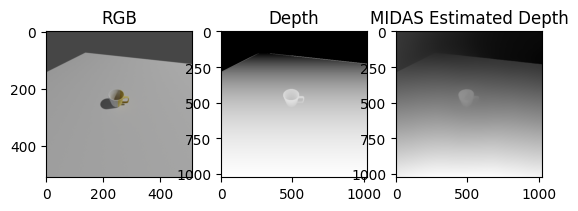

In [115]:
from dsd import DATA_DIR
render_path = DATA_DIR / "renders/mugs/close"
rgb_image = Image.open(render_path / "rgb.png")
rgb_image = load_image(rgb_image)
depth_image = load_image(Image.open(render_path / "depth_image.png"))
depth_image = np.array(depth_image).astype(np.float32)/255
depth_image = 1-depth_image
# normalize
depth_image -= depth_image.min()
depth_image /= depth_image.max()
# interpolate depth image 
depth_image = torch.from_numpy(depth_image)
depth_image = depth_image[...,0]
print(depth_image.shape)
depth_image = torch.nn.functional.interpolate(
    depth_image.unsqueeze(0).unsqueeze(0),
    size=(1024, 1024),
    mode="bicubic",
    align_corners=False,
).squeeze(0)
depth_image = torch.cat([depth_image] * 3, dim=0)
print(depth_image.shape)
depth_image = depth_image.cpu().numpy().transpose(1,2,0)

depth_image = Image.fromarray((depth_image*255).astype(np.uint8))

# convert far is white to black

estimated_depth_image = get_depth_map(rgb_image)

import matplotlib.pyplot as plt
# show both images
plt.subplot(1, 3, 1)
plt.imshow(rgb_image)
# subtitle
plt.title("RGB")
plt.subplot(1, 3, 2)
plt.imshow(depth_image)
plt.title("Depth")
plt.subplot(1, 3, 3)
plt.imshow(estimated_depth_image)
plt.title("MIDAS Estimated Depth")
plt.show()


# note! important to set depth image to 1024x1024!

100%|██████████| 30/30 [00:44<00:00,  1.48s/it]


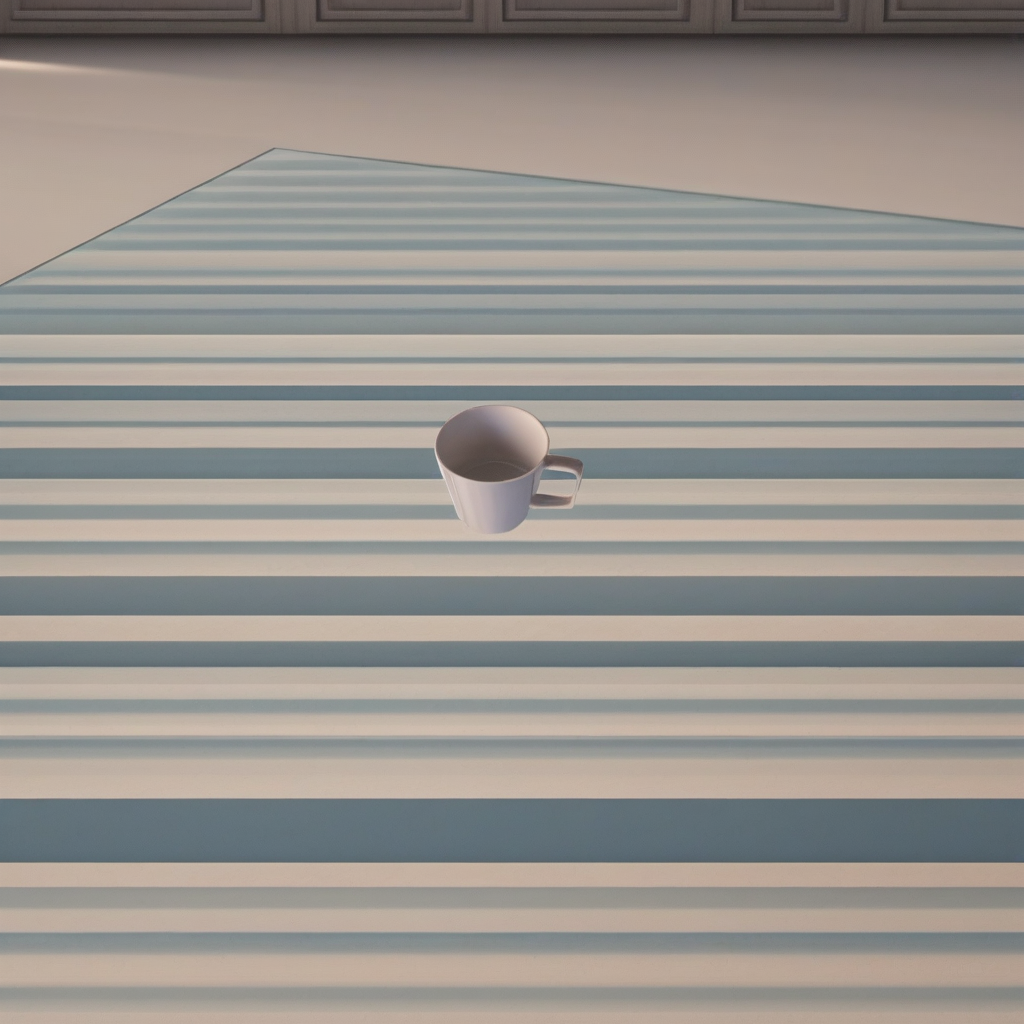

In [138]:
controlnet_conditioning_scale = 1.0
prompt = "empty  mug made of glass, blue table on the background, photorealistic, 4K"

images = pipe(
    prompt,image=depth_image, num_inference_steps=30, controlnet_conditioning_scale=controlnet_conditioning_scale, num_images_per_prompt=4
).images
images[0]


Text(0.5, 1.0, 'Prompted 4')

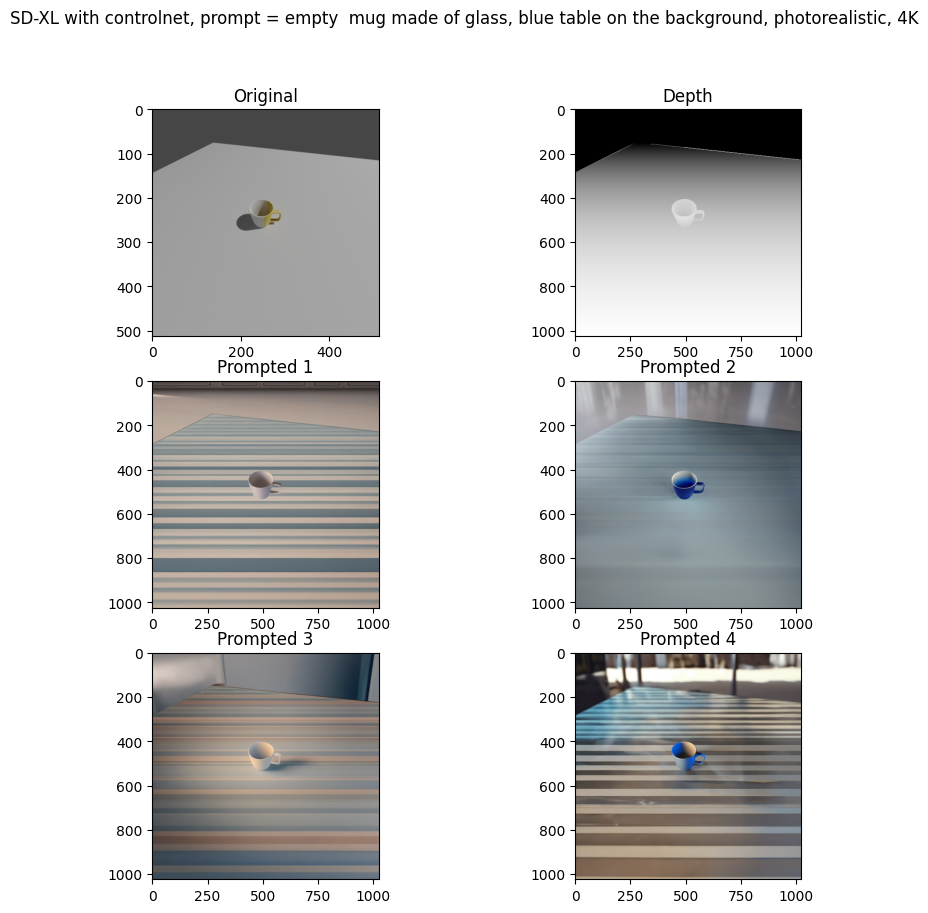

: 

In [139]:
# plot the original image, the depth image 
# and the four prompted images in a 3x2 grid

import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
# set the title
fig.suptitle(f"SD-XL with controlnet, prompt = {prompt}")
axs[0, 0].imshow(rgb_image)
axs[0, 0].set_title("Original")
axs[0, 1].imshow(depth_image)
axs[0, 1].set_title("Depth")
axs[1, 0].imshow(images[0])
axs[1, 0].set_title("Prompted 1")
axs[1, 1].imshow(images[1])
axs[1, 1].set_title("Prompted 2")
axs[2, 0].imshow(images[2])
axs[2, 0].set_title("Prompted 3")
axs[2, 1].imshow(images[3])
axs[2, 1].set_title("Prompted 4")